In [20]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# processing
# import re
import nltk

# Bag-of-Words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Word embedding
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models, layers

# Supress error message from transformers
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Huggingface
import transformers

In [2]:
# Change path to access data
cwd = os.getcwd()
os.chdir('CS254/data')

# Load data
conn = sqlite3.connect('congress.db')
congress = pd.read_sql_query("SELECT * FROM congress", conn)
conn.close()

# Create new DataFrame of just bill summary and party
df = congress[['bill_summary', 'sponsor_party']].copy()
df.columns = ['text', 'y']
df.head()

,text,y
0,"This bill addresses voter access, election int...",D
1,This bill establishes several programs and req...,D
2,This bill establishes new criteria for determi...,D
3,This bill prohibits discrimination based on se...,D
4,American Dream and Promise Act of 2021 This bi...,D


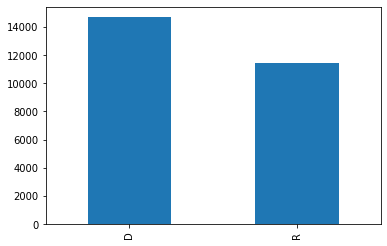

In [114]:
df = df[df['y'] != 'L']
df = df[df['y'] != 'I']

df['y'].value_counts().plot(kind='bar')
plt.show();

In [4]:
def preprocess_text(text, flg_stem=True, flg_lem=False, lst_stopwords=None):
    # convert to lowercase and remove punctuations
    text = re.sub(r'[^\w\s]', '', str(text).lower()).strip()
    
    # Tokenize sentence
    lst_text = text.split()
    
    # Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
        
    # Stemming
    if flg_stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    
    # Lemmatization
    if flg_lem == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # Join text
    text = " ".join(lst_text)
    
    return text

In [30]:
# Get list of stopwords
# lst_stopwords = nltk.corpus.stopwords.words('english')

# Create column of clean text
df['text_clean'] = df.loc[:, 'text'].apply(lambda x: preprocess_text(x, lst_stopwords))

In [37]:
print("Original text\n", df.loc[0, 'text'])
print("\nProcessed text\n", df.loc[0, 'text_clean'])

Original text
 This bill addresses voter access, election integrity and security, campaign finance, and ethics for the three branches of government. Specifically, the bill expands voter registration (e.g., automatic and same-day registration) and voting access (e.g., vote-by-mail and early voting). It also limits removing voters from voter rolls.The bill requires states to establish independent redistricting commissions to carry out congressional redistricting.Additionally, the bill sets forth provisions related to election security, including sharing intelligence information with state election officials, supporting states in securing their election systems, developing a national strategy to protect U.S. democratic institutions, establishing in the legislative branch the National Commission to Protect United States Democratic Institutions, and other provisions to improve the cybersecurity of election systems.Further, the bill addresses campaign finance, including by expanding the proh

In [122]:
# Split dataa
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['y'], test_size=0.2, random_state=0)

# Naive Bayes

In [123]:
# os.chdir(cwd + '/CS254/Code')
# import stopwords
# stpwrds = stopwords.stopwords
# stpwrds = " ".join(stpwrds).lower().split()

# Create a vectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', 
                             lowercase=True, 
                             stop_words='english', 
                             max_features=10000, 
                             ngram_range=(1,2))

# Fit and transform training data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# # Use naive bayes as our classifier
nb_clf = MultinomialNB()

# # Train classifier
nb_clf.fit(X_train_vec, y_train)

# # Predict on test data
y_pred = nb_clf.predict(X_test_vec)

# # Get accuracy score
accuracy_score(y_test, y_pred)

0.7050277193653222

In [117]:
classes = np.unique(y_test)
classes

array(['D', 'R'], dtype=object)

In [81]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

              precision    recall  f1-score   support

           D       0.73      0.76      0.74      2933
           R       0.68      0.63      0.65      2298

    accuracy                           0.71      5231
   macro avg       0.70      0.70      0.70      5231
weighted avg       0.70      0.71      0.70      5231



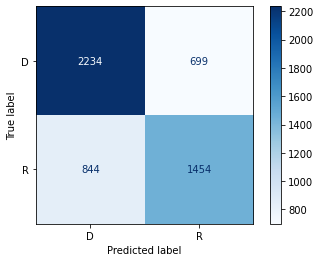

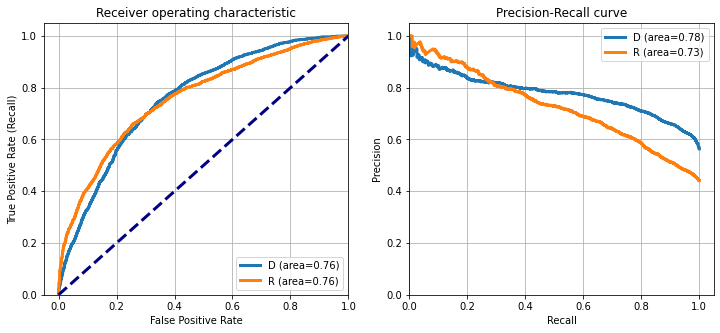

In [127]:
# Get precision/recall/f1 scores
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plot_confusion_matrix(nb_clf, X_test_vec,  y_test, cmap='Blues')

# Visualize precision recall curve
classes = np.unique(y_test.values)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
predicted_prob = nb_clf.predict_proba(X_test_vec)

# Plot ROC
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:, i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i],auc(fpr, tpr)))
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show();

# SVC

In [92]:
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC

In [141]:
svc_clf = SVC(random_state=0, probability=True)
svc_clf.fit(X_train_vec, y_train)

SVC(probability=True, random_state=0)

In [142]:
r_probs = np.zeros(len(y_test))
nb_probs = nb_clf.predict_proba(X_test_vec)
svc_probs = svc_clf.predict_proba(X_test_vec)

In [147]:
# Print AUROC scores
r_auc = roc_auc_score(y_test, r_probs)
nb_auc = roc_auc_score(y_test, nb_probs[:,1])
svc_auc = roc_auc_score(y_test, svc_probs[:,1])

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
print('SVC: AUROC = %.3f' % (svc_auc))

Random (chance) Prediction: AUROC = 0.500
Naive Bayes: AUROC = 0.759
SVC: AUROC = 0.862


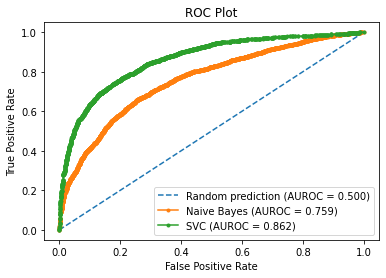

In [156]:
# Remap y values to numeric
y_test_num = y_test.replace({'D':0, 'R':1})

# Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_test_num, r_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test_num, nb_probs[:,1])
svc_fpr, svc_tpr, _ = roc_curve(y_test_num, svc_probs[:,1])

# Plot
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC (AUROC = %0.3f)' % svc_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### References

1. https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
2. https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb